# Tephra2 Inversion — Simulation Demo

This notebook does three main things:

1. *(Optional)* Prepare a synthetic Cerro Negro–style dataset via `scripts.sim.setup`.
2. *(Optional)* Run the full simulation grid via `scripts.sim.simulate`.
3. Post-process the results using `scripts.sim.aggregate_sim_visuals` to produce:

   - Multi-run trace + marginal plots for selected priors and hyperparameters.
   - 7x7 prior-grid heatmaps of **relative error** and (optionally) **runtime**
     for each inversion method.
   - Single-run diagnostics (trace + marginal) with ground-truth overlays.


In [1]:
import os
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "DejaVu Sans"
logging.getLogger("matplotlib").setLevel(logging.WARNING)

# Choose which experiment config to use
USE_TEST_CONFIG = False

if USE_TEST_CONFIG:
    from scripts.sim import exp_config_test as EXP
    CONFIG_MODULE = "scripts.sim.exp_config_test"
else:
    from scripts.sim import exp_config as EXP
    CONFIG_MODULE = "scripts.sim.exp_config"

from scripts.sim.aggregate_sim_visuals import (
    plot_single_config_traces_and_marginals,
    plot_accuracy_time_heatmaps_for_model,
    plot_single_config_traces_and_marginals
)

from scripts.sim.interactive_scatter import (
    make_interactive_scatter_all_models,
    write_hover_interactive_html,
)

SIM_OUTPUT_DIR = Path(EXP.SIM_OUTPUT_DIR)
N_REPEATS = EXP.N_REPEATS

true_plume_height = 7000.0
true_eruption_mass = 2.4e10

print(f"CONFIG_MODULE = {CONFIG_MODULE}")
print(f"SIM_OUTPUT_DIR = {SIM_OUTPUT_DIR}")
print(f"N_REPEATS      = {N_REPEATS}")

CONFIG_MODULE = scripts.sim.exp_config
SIM_OUTPUT_DIR = data_sim_cerro/experiments
N_REPEATS      = 1


## Optional: build simulated dataset (`scripts.sim.setup`)

Run this **once** to create the `data_sim_cerro/` tree from an aggregated
Cerro Negro CSV. After it has been created, you can leave `RUN_SETUP=False` for subsequent runs.

In [2]:
RUN_SETUP = False  # flip to True the first time you prepare data_sim_cerro

SETUP_CMD = (
    "python -m scripts.sim.setup "
    "data_std/cn_std_agg.csv "
    "--out-root data_sim_cerro "
    "--vent-easting 532400 "
    "--vent-northing 1382525 "
    "--vent-elev 100 "
    "--plume-height 7000 "
    "--eruption-mass 2.4e10"
)

if RUN_SETUP:
    print("Running synthetic setup via:\n", SETUP_CMD)
    ret = os.system(SETUP_CMD)
    print(f"\nsetup exit code: {ret}")
else:
    print("Skipping setup (RUN_SETUP=False).")
    print("Set RUN_SETUP=True if you need to create or refresh data_sim_cerro/.")

Skipping setup (RUN_SETUP=False).
Set RUN_SETUP=True if you need to create or refresh data_sim_cerro/.


## Optional: launch simulations (`scripts.sim.simulate`)

This will run *all* combinations defined in the chosen config module (`exp_config_test` or `exp_config`) for N_REPEATS.

Only enable this when you actually want to generate or refresh the experiment results in `SIM_OUTPUT_DIR`.

In [3]:
RUN_SIM = True  # flip to True to (re)run the full grid

if RUN_SIM:
    print(f"Running simulations with config module: {CONFIG_MODULE}")
    cmd = f"python -m scripts.sim.simulate --config-module {CONFIG_MODULE} --plot-winds"
    ret = os.system(cmd)
    print(f"\nsimulate exit code: {ret}")
else:
    print("Skipping simulation (RUN_SIM=False).")
    print("Set RUN_SIM=True to run the full experiment grid.")

Running simulations with config module: scripts.sim.exp_config
[OK] wind plot saved: data_sim_cerro/experiments/plots/wind_profile_wind.png
2026-01-16 05:17:34,183 - scripts.tephra_inversion - INFO - TephraInversion initialized
[MCMC] iter 10000/10000  acc=0.305  h=16776.1  lnM=24.530
[SIM] run_id=1 sim=0 model=mcmc h_scale=2 m_scale=2 runtime=186.81s
2026-01-16 05:20:41,003 - scripts.tephra_inversion - INFO - TephraInversion initialized
[MCMC] iter 100000/100000  acc=0.304  h=20729.3  lnM=24.838
[SIM] run_id=2 sim=0 model=mcmc h_scale=2 m_scale=2 runtime=1859.07s
2026-01-16 05:51:40,155 - scripts.tephra_inversion - INFO - TephraInversion initialized

[SA] Restart 1/1  (T0=1.0000, alpha=0.999000)
[SA] iter 10000/10000  T=0.0000  acc=0.050  h=17013.0  lnM=24.583  best=-72.0047
[SIM] run_id=3 sim=0 model=sa h_scale=2 m_scale=2 runtime=186.80s
2026-01-16 05:54:46,967 - scripts.tephra_inversion - INFO - TephraInversion initialized

[SA] Restart 1/5  (T0=1.0000, alpha=0.999000)
[SA] iter 10

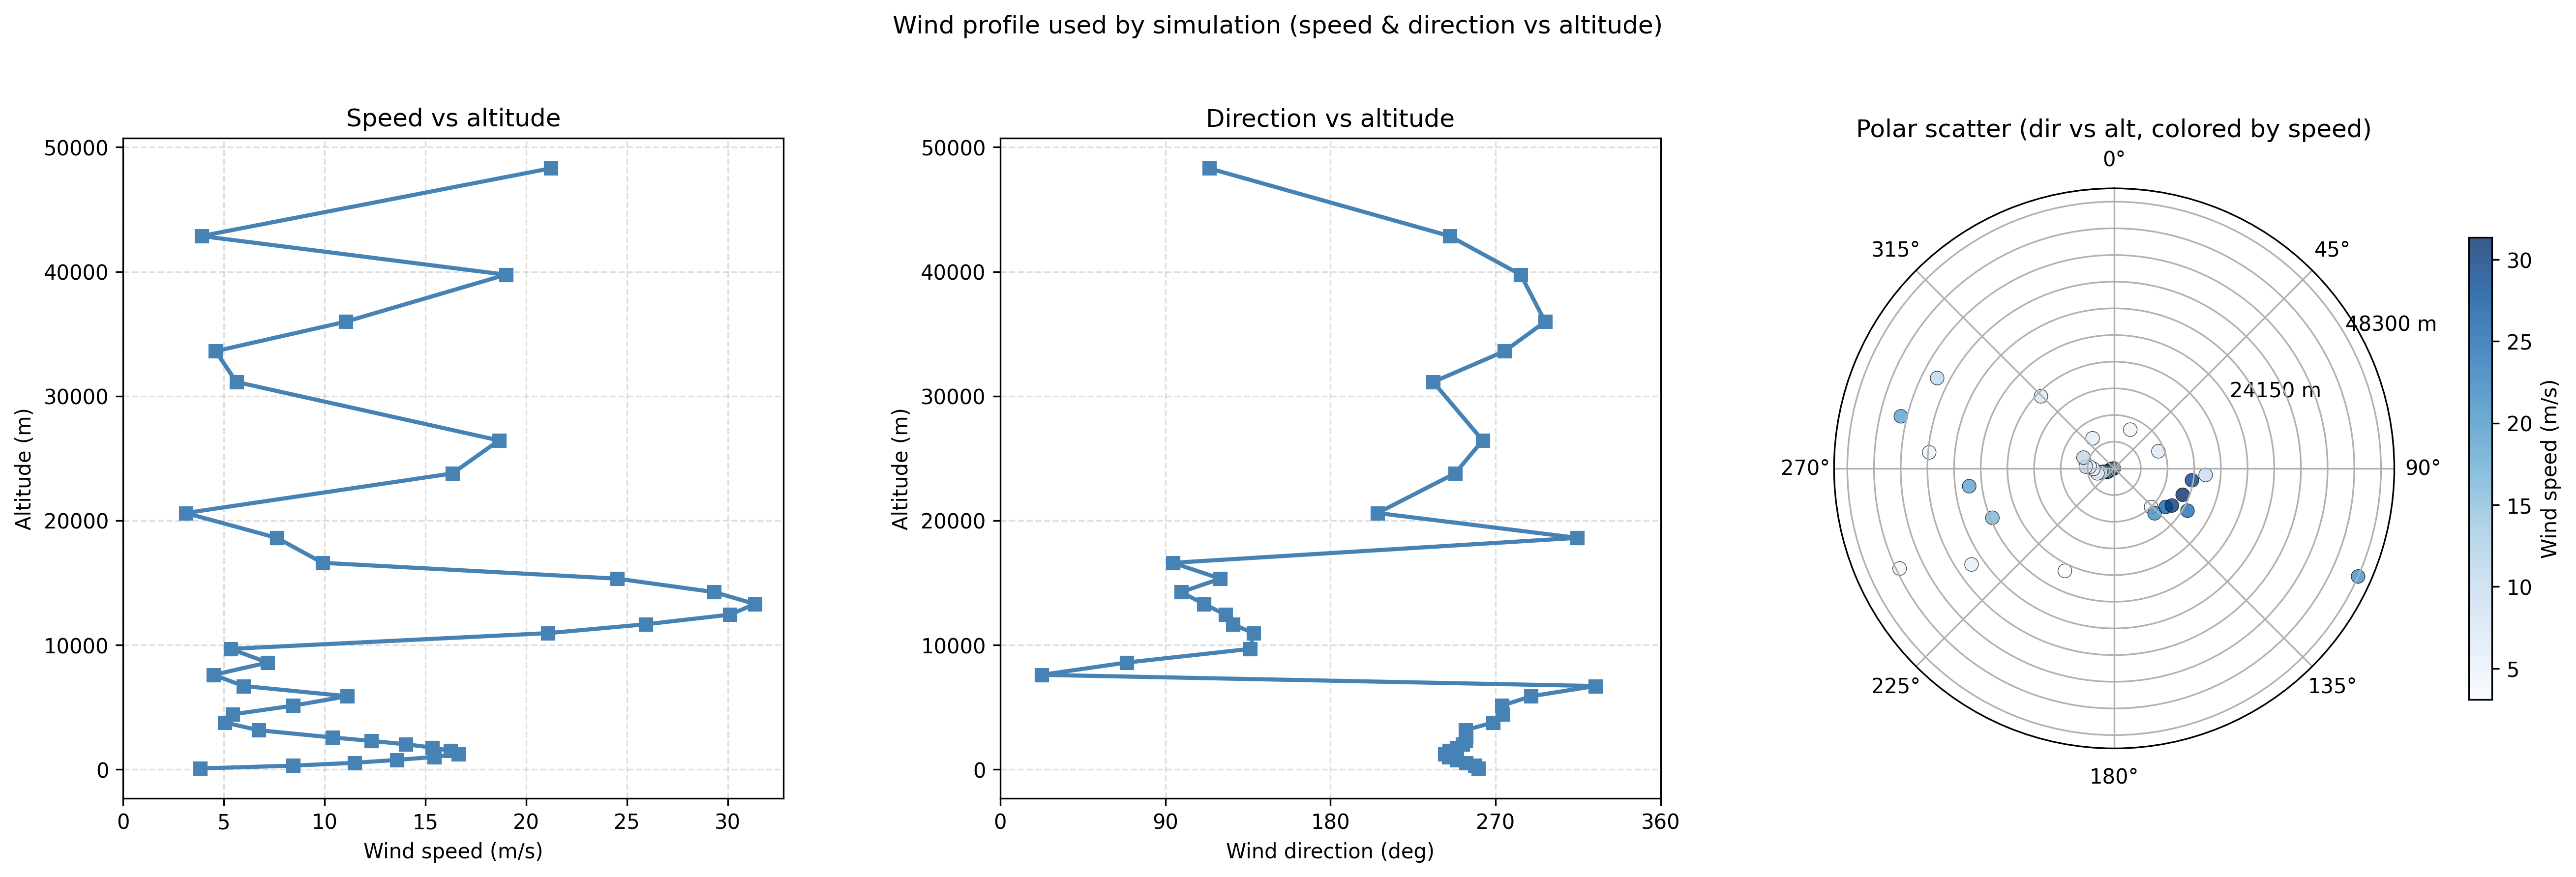

Displayed: data_sim_cerro/experiments/plots/wind_profile_wind.png


In [4]:
from IPython.display import Image, display
from pathlib import Path

# if you already have SIM_OUTPUT_DIR = Path(EXP.SIM_OUTPUT_DIR)
plot_dir = Path(EXP.SIM_OUTPUT_DIR) / "plots"
latest = sorted(plot_dir.glob("wind_profile_*.png"))[-1]
display(Image(filename=str(latest)))
print("Displayed:", latest)

## Display all aggregate plots (traces + marginals)

Model: SA


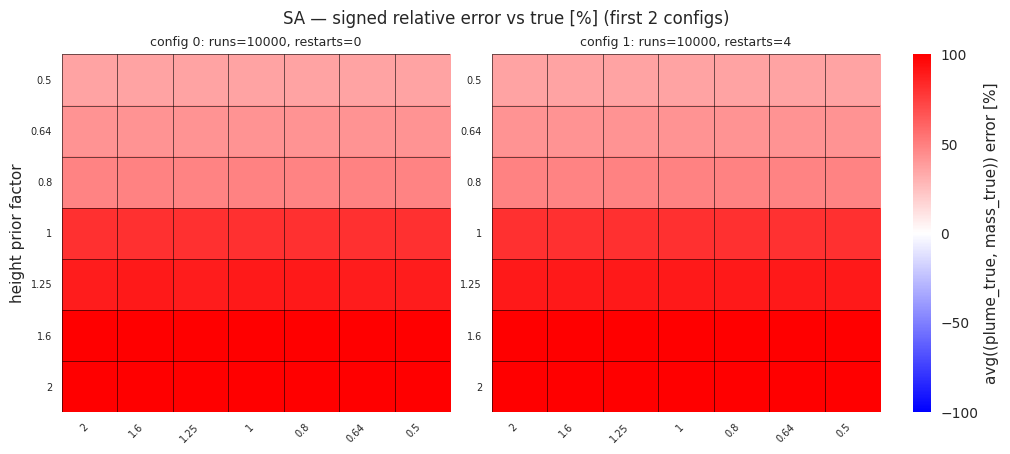

  saved: data_sim_cerro/output_heatmaps/sa_all_configs_accuracy.png
Model: PSO


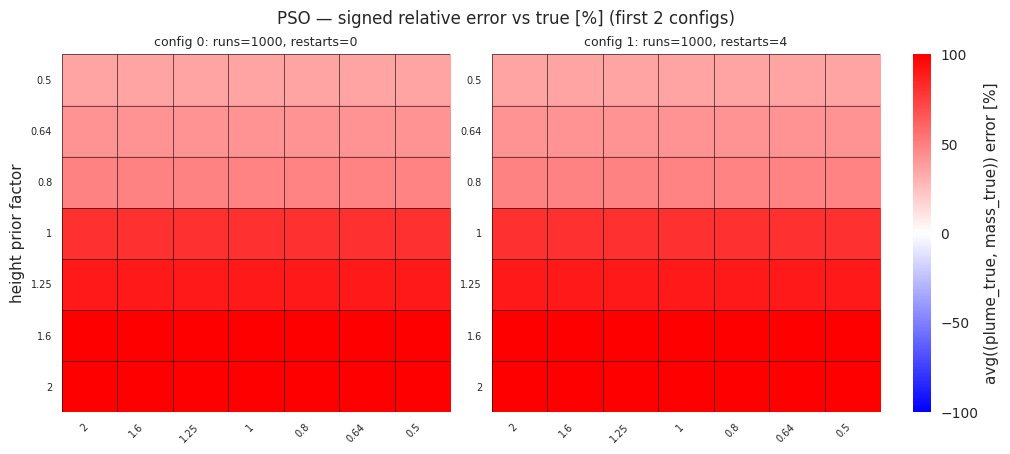

  saved: data_sim_cerro/output_heatmaps/pso_all_configs_accuracy.png
Model: ES


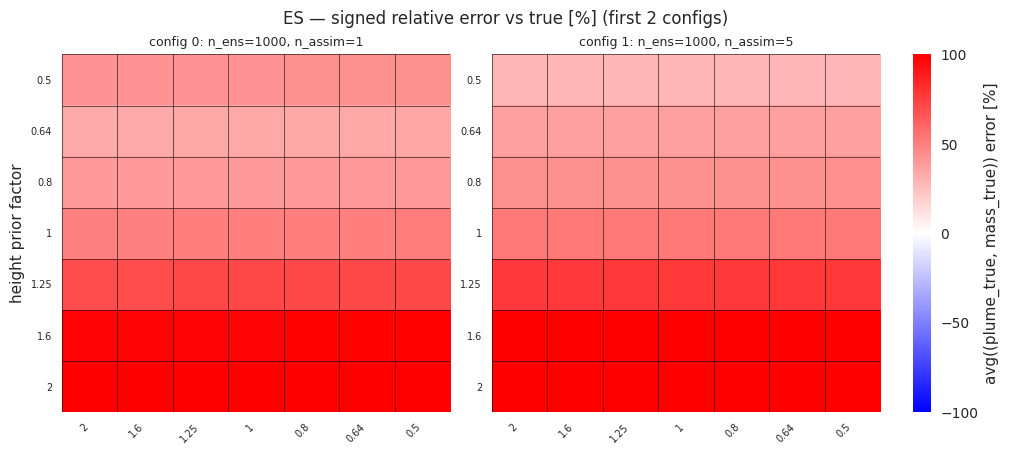

  saved: data_sim_cerro/output_heatmaps/es_all_configs_accuracy.png
Model: MCMC


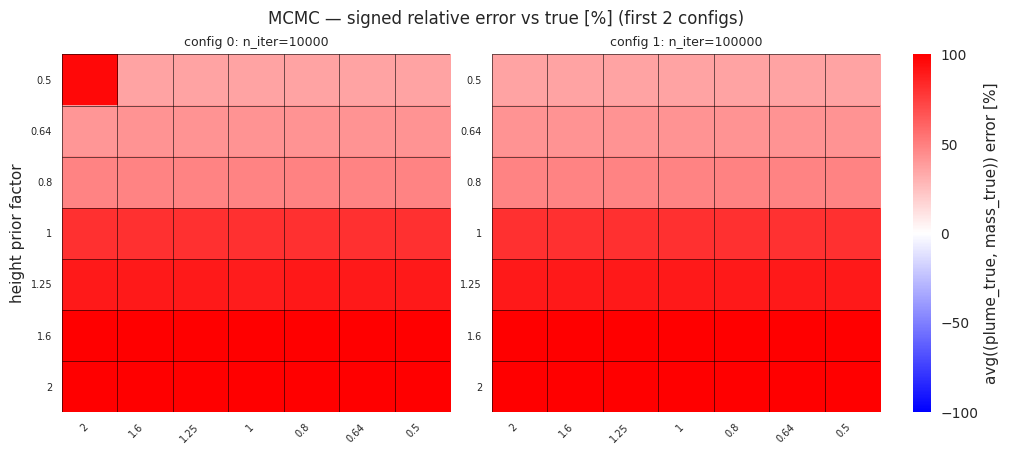

  saved: data_sim_cerro/output_heatmaps/mcmc_all_configs_accuracy.png


In [5]:
for model in ["sa", "pso", "es", "mcmc"]:
    print(f"Model: {model.upper()}")
    png = plot_accuracy_time_heatmaps_for_model(
        sim_output_dir=SIM_OUTPUT_DIR,
        model=model,
        true_plume_height=true_plume_height,
        true_eruption_mass=true_eruption_mass,
        EXP=EXP,
        show=True,
    )
    print("  saved:", png)


In [6]:
fig = make_interactive_scatter_all_models(
    sim_output_dir=SIM_OUTPUT_DIR,
    EXP=EXP,
    true_plume_height=true_plume_height,
    true_eruption_mass=true_eruption_mass,
    models=("mcmc", "sa", "pso", "es"),
    max_configs=4,
)

# Normal inline Plotly (no custom hover behavior) if you want:
fig.show()

# Or write advanced-hover HTML:
html_path = SIM_OUTPUT_DIR.parent / "interactive_scatter_all_models_hover.html"
write_hover_interactive_html(fig, html_path)

Wrote interactive HTML with hover behavior to data_sim_cerro/interactive_scatter_all_models_hover.html


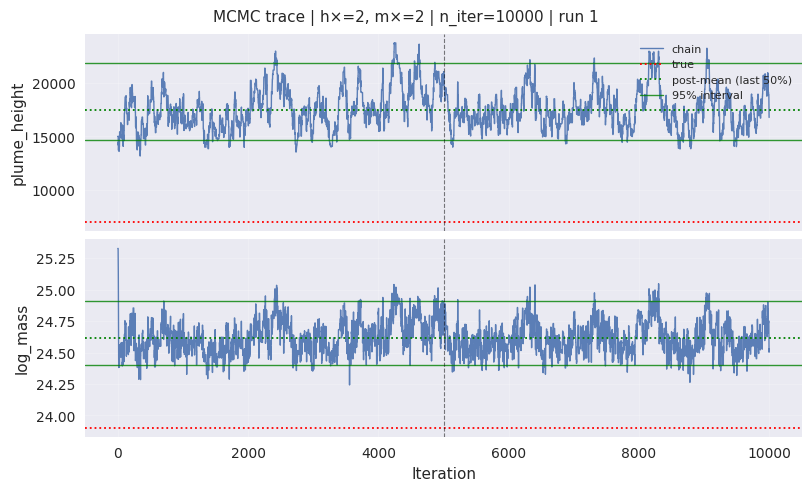

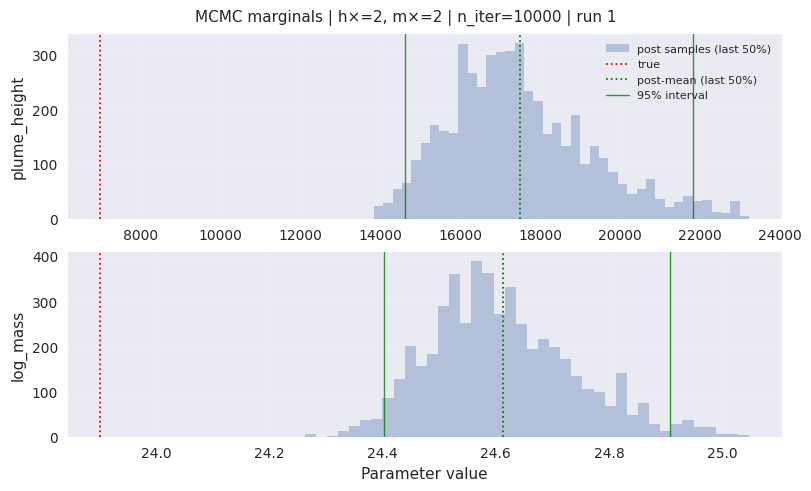

data_sim_cerro/output_simple/mcmc_h2_m2_cfg00_run1_trace.png data_sim_cerro/output_simple/mcmc_h2_m2_cfg00_run1_marginals.png


In [7]:
trace_path, marg_path = plot_single_config_traces_and_marginals(
    sim_output_dir=SIM_OUTPUT_DIR,
    model="mcmc",
    prior_factors=(2.0, 2.0),       # (height_factor, mass_factor)
    config_index=0,                 # e.g. n_iter=100000
    run_index=0,
    true_plume_height=true_plume_height,
    true_eruption_mass=true_eruption_mass,
    show=True,
)
print(trace_path, marg_path)

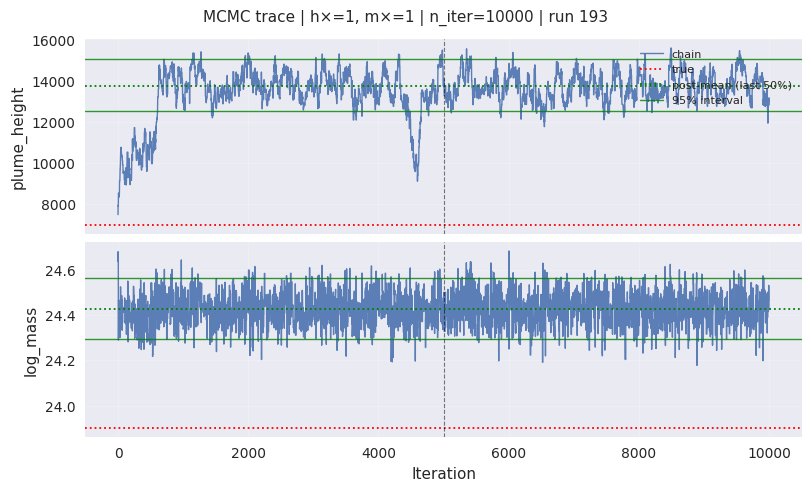

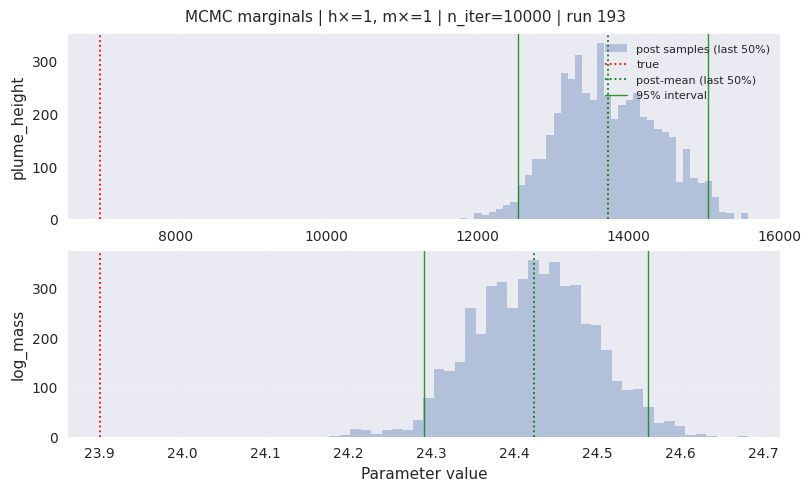

data_sim_cerro/output_simple/mcmc_h1_m1_cfg00_run193_trace.png data_sim_cerro/output_simple/mcmc_h1_m1_cfg00_run193_marginals.png


In [8]:
trace_path, marg_path = plot_single_config_traces_and_marginals(
    sim_output_dir=SIM_OUTPUT_DIR,
    model="mcmc",
    prior_factors=(1.0, 1.0),       # (height_factor, mass_factor)
    config_index=0,                 # e.g. n_iter=100000
    run_index=0,
    true_plume_height=true_plume_height,
    true_eruption_mass=true_eruption_mass,
    show=True,
)
print(trace_path, marg_path)

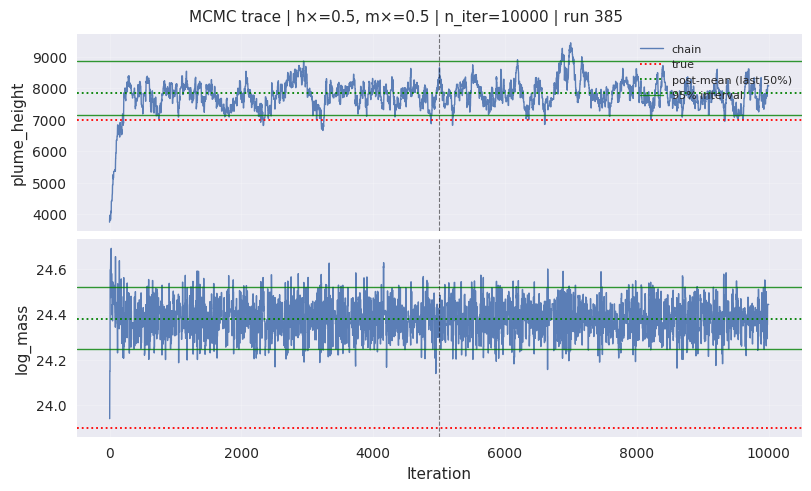

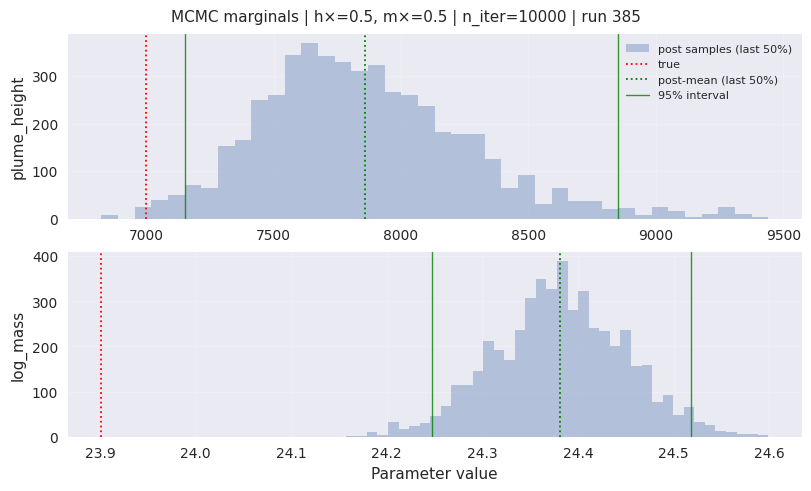

data_sim_cerro/output_simple/mcmc_h0.5_m0.5_cfg00_run385_trace.png data_sim_cerro/output_simple/mcmc_h0.5_m0.5_cfg00_run385_marginals.png


In [9]:
trace_path, marg_path = plot_single_config_traces_and_marginals(
    sim_output_dir=SIM_OUTPUT_DIR,
    model="mcmc",
    prior_factors=(0.5, 0.5),       # (height_factor, mass_factor)
    config_index=0,                 # e.g. n_iter=100000
    run_index=0,
    true_plume_height=true_plume_height,
    true_eruption_mass=true_eruption_mass,
    show=True,
)
print(trace_path, marg_path)

In [10]:
from scripts.sim.aggregate_sim_visuals import plot_single_config_traces_and_marginals

prior_values = EXP.PRIOR_FACTORS  # length 7

for ind in range(1):
    for mod in ["sa", "pso", "es", "mcmc"]:
        for i, h_factor in enumerate(prior_values):
            for j, m_factor in enumerate(prior_values):
                print(f"=== hx={h_factor:g}, mx={m_factor:g} (cell [{i},{j}]) ===")

                trace_path, marg_path = plot_single_config_traces_and_marginals(
                    sim_output_dir=SIM_OUTPUT_DIR,
                    model=mod,
                    prior_factors=(h_factor, m_factor),
                    config_index=ind,
                    run_index=0,
                    true_plume_height=true_plume_height,
                    true_eruption_mass=true_eruption_mass,
                    show=False,
                )
                print("  trace:", trace_path)
                print("  marg: ", marg_path)

=== hx=2, mx=2 (cell [0,0]) ===
  trace: data_sim_cerro/output_simple/sa_h2_m2_cfg00_run3_trace.png
  marg:  data_sim_cerro/output_simple/sa_h2_m2_cfg00_run3_marginals.png
=== hx=2, mx=1.6 (cell [0,1]) ===
  trace: data_sim_cerro/output_simple/sa_h2_m1.6_cfg00_run11_trace.png
  marg:  data_sim_cerro/output_simple/sa_h2_m1.6_cfg00_run11_marginals.png
=== hx=2, mx=1.25 (cell [0,2]) ===
  trace: data_sim_cerro/output_simple/sa_h2_m1.25_cfg00_run19_trace.png
  marg:  data_sim_cerro/output_simple/sa_h2_m1.25_cfg00_run19_marginals.png
=== hx=2, mx=1 (cell [0,3]) ===
  trace: data_sim_cerro/output_simple/sa_h2_m1_cfg00_run27_trace.png
  marg:  data_sim_cerro/output_simple/sa_h2_m1_cfg00_run27_marginals.png
=== hx=2, mx=0.8 (cell [0,4]) ===
  trace: data_sim_cerro/output_simple/sa_h2_m0.8_cfg00_run35_trace.png
  marg:  data_sim_cerro/output_simple/sa_h2_m0.8_cfg00_run35_marginals.png
=== hx=2, mx=0.64 (cell [0,5]) ===
  trace: data_sim_cerro/output_simple/sa_h2_m0.64_cfg00_run43_trace.png
  ma

In [11]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_7x7_config_grid(
    sim_output_dir: Path,
    EXP,
    model: str = "mcmc",
    config_index: int = 3,
    kind: str = "marginals",  # "marginals" or "trace"
    figsize_per_cell: float = 2.0,
):
    """
    Display a 7x7 grid of pre-generated trace/marginal PNGs for a given
    model + config_index, one cell per (height_factor, mass_factor).

    kind: "marginals" -> *_marginals.png
          "trace"     -> *_trace.png
    """
    model = model.lower()
    factors = EXP.PRIOR_FACTORS
    n = len(factors)

    root_out = Path(sim_output_dir).parent / "output_simple"

    fig, axes = plt.subplots(
        n, n,
        figsize=(figsize_per_cell * n, figsize_per_cell * n),
        constrained_layout=True,
    )

    for i, h_factor in enumerate(factors):
        for j, m_factor in enumerate(factors):
            ax = axes[i, j]
            h_label = f"{h_factor:g}"
            m_label = f"{m_factor:g}"

            pattern = f"{model}_h{h_label}_m{m_label}_cfg{config_index:02d}_run*_{kind}.png"
            matches = sorted(root_out.glob(pattern))

            if matches:
                img = mpimg.imread(matches[0])
                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.set_xticks([])
                ax.set_yticks([])
                ax.text(
                    0.5, 0.5,
                    "N/A",
                    ha="center", va="center",
                    fontsize=8,
                )

            ax.text(
                0.02, 0.98,
                f"hx={h_label}\nmx={m_label}",
                ha="left", va="top",
                fontsize=6,
                transform=ax.transAxes,
                bbox=dict(
                    boxstyle="round,pad=0.15",
                    facecolor="white",
                    edgecolor="none",
                    alpha=0.6,
                ),
            )

    # Overall title
    fig.suptitle(
        f"{model.upper()} {kind} — 7x7 prior grid (config {config_index})",
        fontsize=14,
    )

    plt.show()

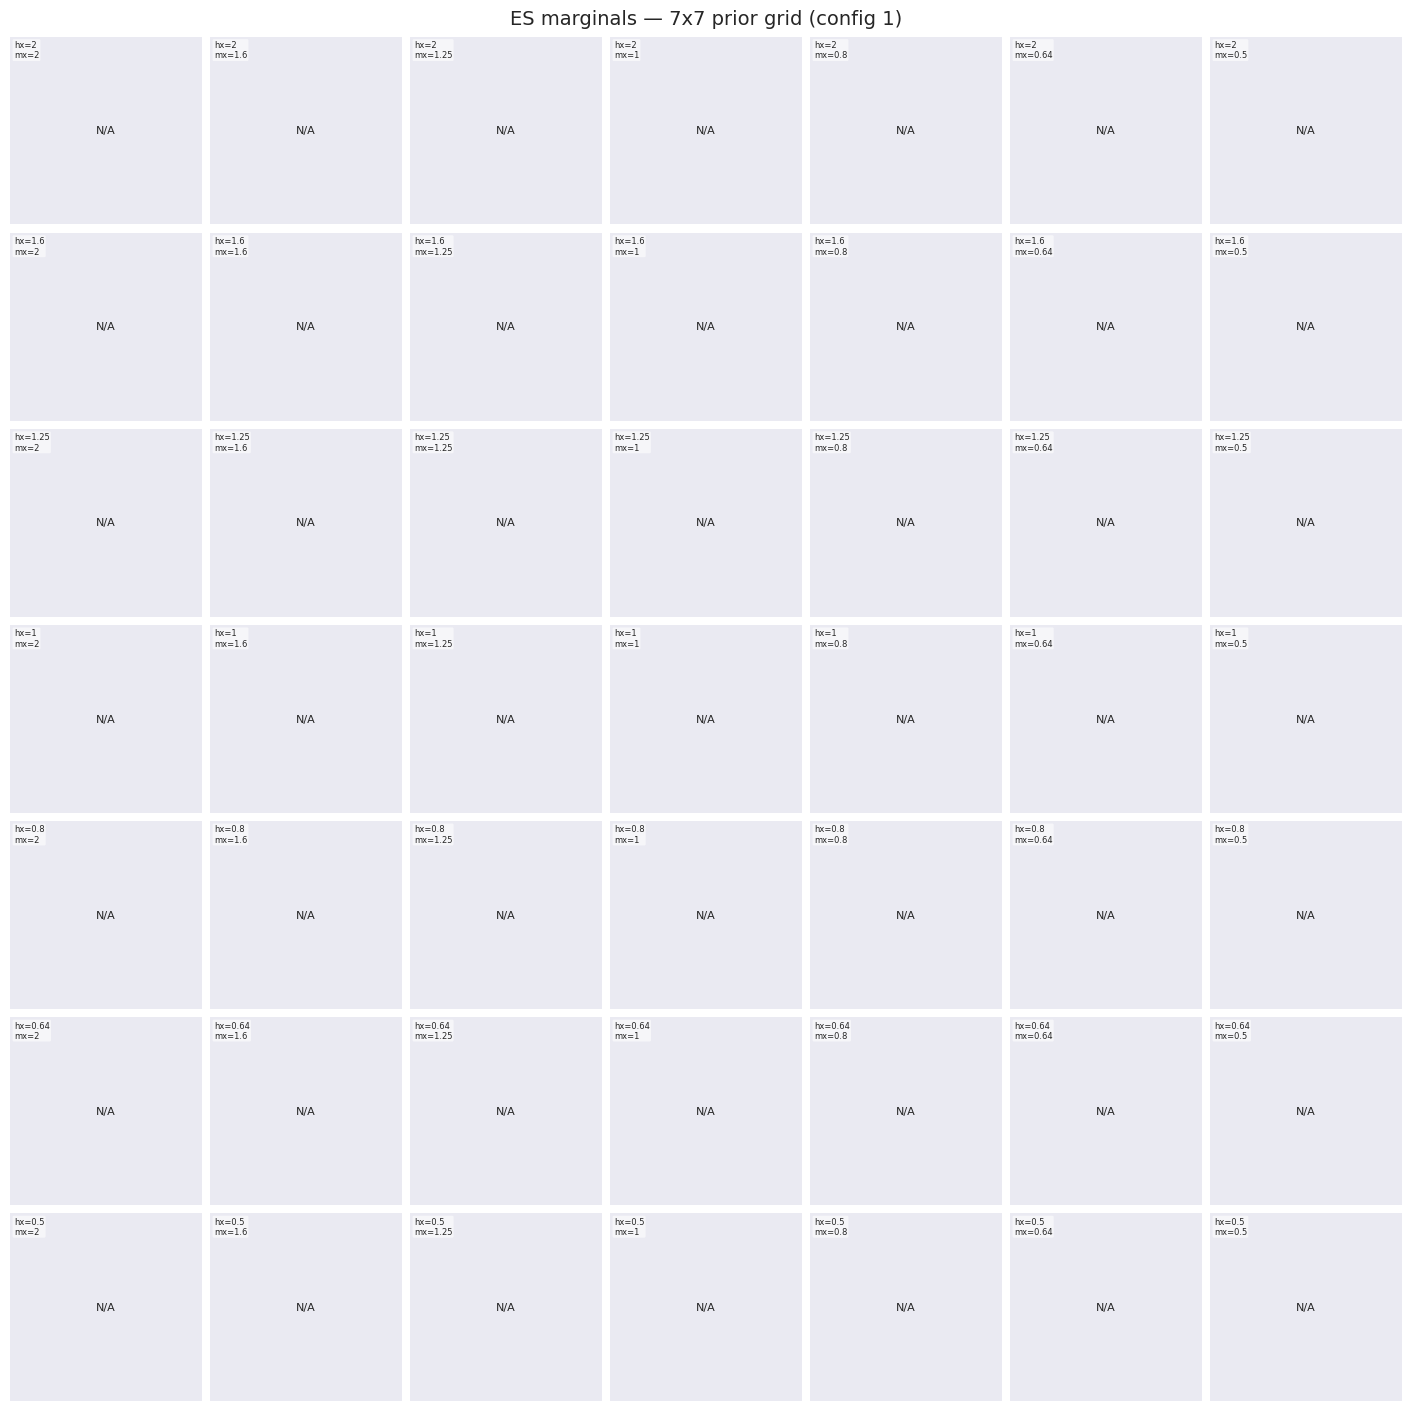

In [12]:
# 7x7 grid of marginals
show_7x7_config_grid(
    sim_output_dir=SIM_OUTPUT_DIR,
    EXP=EXP,
    model="es",
    config_index=1,
    kind="marginals",
    figsize_per_cell=2.0,
)


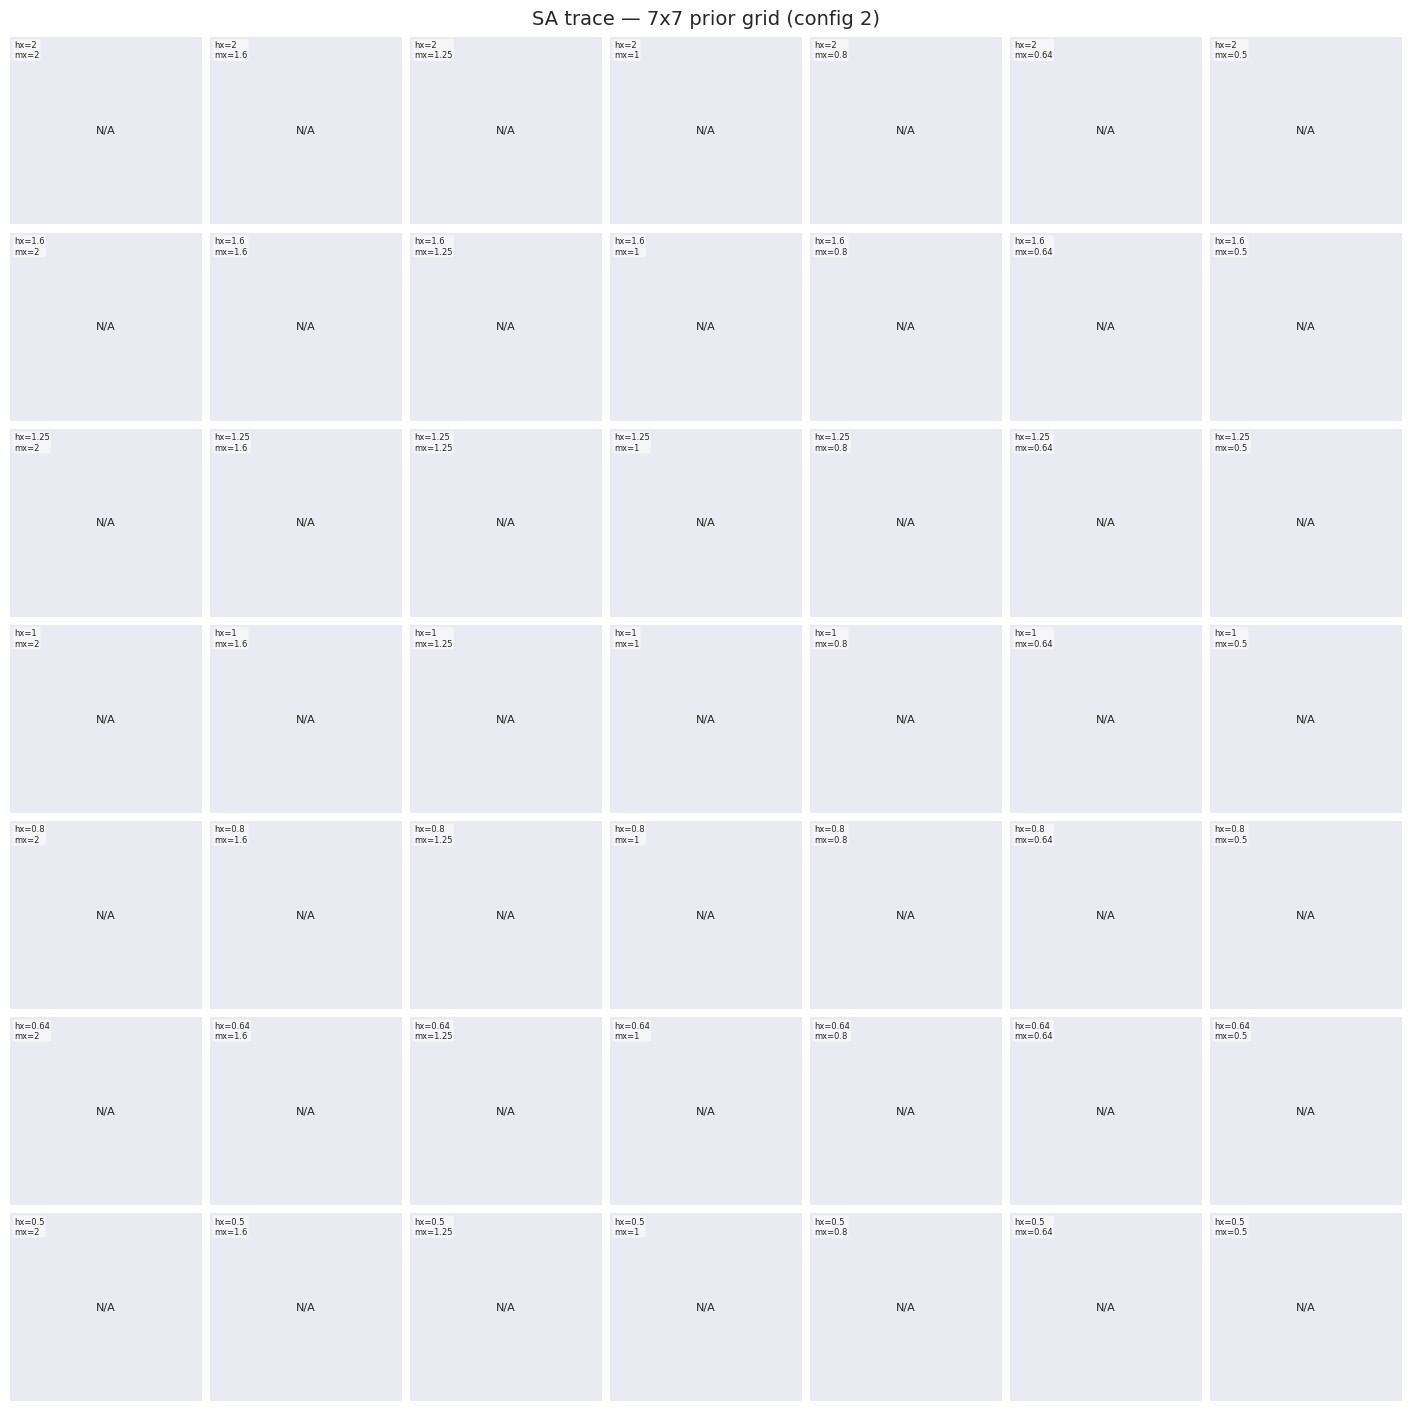

In [13]:
# 7x7 grid of traces
show_7x7_config_grid(
    sim_output_dir=SIM_OUTPUT_DIR,
    EXP=EXP,
    model="sa",
    config_index=2,
    kind="trace",
    figsize_per_cell=2.0,
)
